![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/finance-nlp/02.Sentence_Splitting_Tokenization.ipynb)

#🎬 Installation

In [ ]:
! pip install -q johnsnowlabs

##🔗 Automatic Installation
Using my.johnsnowlabs.com SSO

In [2]:
from johnsnowlabs import nlp, finance

# nlp.install(force_browser=True)

##🔗 Manual downloading
If you are not registered in my.johnsnowlabs.com, you received a license via e-email or you are using Safari, you may need to do a manual update of the license.

- Go to my.johnsnowlabs.com
- Download your license
- Upload it using the following command

In [ ]:
from google.colab import files
print('Please Upload your John Snow Labs License using the button below')
license_keys = files.upload()

- Install it

In [ ]:
nlp.install()

#📌 Starting

In [8]:
spark = nlp.start()

👌 Detected license file /content/spark_nlp_for_healthcare_spark_ocr_7187 (2).json
👌 Launched cpu optimized session with with: 🚀Spark-NLP==4.3.0, 💊Spark-Healthcare==4.3.0, running on ⚡ PySpark==3.1.2


#🔎 2. Splitting for training word-based classifiers (as Named Entity Recognition)

In the previous notebook we have seen how splitting documents and pages is important for **Text Classification**: `you may leave in too much information, or too little`.

For **Word (token) Classification** splitting is also very important. We usually split **by sentences**, although they may be other use cases where you may need information from the context.

This is the usual TextSplitter pipeline which will be used by default for training our NER models.

📚Default `TextSplitter()` breaks texts by lines using the following patterns:

```
- Lists ("(i), (ii)", "(a), (b)", "1., 2.")
- Numbers
- Abbreviations
- Punctuations
- Multiple Periods
- Geo-Locations/Coordinates ("N°. 1026.253.553.")
- Ellipsis ("...")
- In-between punctuations
- Quotation marks
- Exclamation Points
- Basic Breakers (".", ";")
```

In [9]:
document_assembler = nlp.DocumentAssembler() \
        .setInputCol("text") \
        .setOutputCol("document")

text_splitter = finance.TextSplitter() \
    .setInputCols(["document"]) \
    .setOutputCol("sentences") \
    .setExplodeSentences(True)

nlp_pipeline = nlp.Pipeline(stages=[
    document_assembler,
    text_splitter])

In [10]:
text = """The IC and SoC design excellence requires technologies for custom IC, digital IC design and signoff, and functional verification, and leverages pre-built semiconductor IP. These tools, IP and associated services are specifically designed to meet the growing requirements of engineers designing increasingly complex chips across analog, digital and mixed-signal domains, and perform the associated verification tasks, including validation of low-level software running on the silicon model, thereby enabling design teams to manage complexity and verification throughput without commensurately increasing the team size or extending the project schedule, while reducing technical risks. The second layer of our strategy centers around system innovation. It includes tools and services used for system design of the packages that encapsulate the ICs and the PCBs, system simulation which includes electromagnetic, electro-thermal and other multi-physics analysis necessary as part of optimizing the full system’s performance, radio frequency (“RF”) and microwave systems, and embedded software. The third layer of our strategy addresses pervasive intelligence in new electronics. It starts with providing solutions and services to develop AI-enhanced systems and includes machine learning and deep learning capabilities being added to the Cadence"""

In [11]:
text

'The IC and SoC design excellence requires technologies for custom IC, digital IC design and signoff, and functional verification, and leverages pre-built semiconductor IP. These tools, IP and associated services are specifically designed to meet the growing requirements of engineers designing increasingly complex chips across analog, digital and mixed-signal domains, and perform the associated verification tasks, including validation of low-level software running on the silicon model, thereby enabling design teams to manage complexity and verification throughput without commensurately increasing the team size or extending the project schedule, while reducing technical risks. The second layer of our strategy centers around system innovation. It includes tools and services used for system design of the packages that encapsulate the ICs and the PCBs, system simulation which includes electromagnetic, electro-thermal and other multi-physics analysis necessary as part of optimizing the full

In [12]:
df = spark.createDataFrame([[text]]).toDF("text")

res = nlp_pipeline.fit(df).transform(df)

In [13]:
res.select('sentences.result').show()

+--------------------+
|              result|
+--------------------+
|[The IC and SoC d...|
|[These tools, IP ...|
|[The second layer...|
|[It includes tool...|
|[The third layer ...|
|[It starts with p...|
+--------------------+



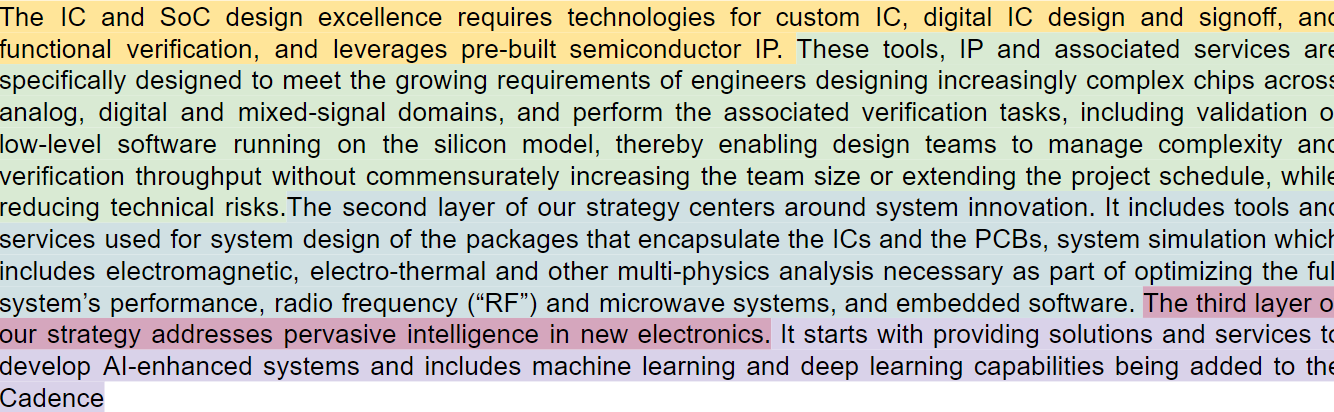

But you already know from previous notebook that you can customize those boundaries using `setCustomBounds()`.

In addition, you have a Deep Learning pretrained TextSplitter, called `SentenceDetectorDLModel`.

In [14]:
document_assembler = nlp.DocumentAssembler() \
        .setInputCol("text") \
        .setOutputCol("document")

sentence_detector = nlp.SentenceDetectorDLModel()\
    .setInputCols(["document"]) \
    .setOutputCol("sentence")

nlp_pipeline = nlp.Pipeline(stages=[
    document_assembler,
    sentence_detector])

That model is `pretrained`, which means it learnt during training time the boundaries of sentences and it can't be modified.

You can train your SentenceDetector using DeepLearning as explained here: https://nlp.johnsnowlabs.com/docs/en/annotators#sentencedetectordl

###✔ Length restriction of Transformers

📚Transformers have restrictions in terms of the number of tokens they can process, as shown in the list below. Any subsequent token after that limit of subwords will be discarded from the sentence.

| Transformer | Limit of tokens |
|-------------|-----------------|
| BERT        | 512             |
| XLNet       | 512             |
| RoBERTa     | 512             |
| XLM-RoBERTa | 512             |
| Electra     | 512             |
| Longformers*| 4096 (8 x BERT) |


As you can see, most of the transformers work with a token limit of 512. There are several exceptions, as Longformer and BigBird, which allow up to 4096.

#🔎 Tokenization
Tokenization is the NLP task in charge of splitting sentences in smaller pieces, usually words. Althought it's a `splitting` task, we don't call it splitting, we call it `tokenization`.

The main component to do tokenization is the `Tokenizer`. It will get the `tokens` from the piece of text you pass to it.

You can tokenize at `whole-text` level:

In [15]:
document_assembler = nlp.DocumentAssembler() \
    .setInputCol("text") \
    .setOutputCol("document")

tokenizer = nlp.Tokenizer()\
    .setInputCols(["document"]) \
    .setOutputCol("tokens")

nlp_pipeline = nlp.Pipeline(stages=[
    document_assembler,
    tokenizer])

... but more frequently we do it at `sentence` or `paragraph` level, using it after TextSplitter.

In [16]:
document_assembler = nlp.DocumentAssembler() \
    .setInputCol("text") \
    .setOutputCol("document")

text_splitter = finance.TextSplitter() \
    .setInputCols(["document"])\
    .setOutputCol("sentences")\
    .setExplodeSentences(True)

tokenizer = nlp.Tokenizer()\
    .setInputCols(["sentences"]) \
    .setOutputCol("tokens")

nlp_pipeline = nlp.Pipeline(stages=[
    document_assembler,
    text_splitter,
    tokenizer])

In [17]:
fit = nlp_pipeline.fit(df)

lp = nlp.LightPipeline(fit)

res = lp.fullAnnotate(text)

In [18]:
sentences = res[0]['sentences']
tokens = res[0]['tokens']

for i in range(len(sentences)):
  sen_tokens = [x.result for x in tokens if x.metadata['sentence'] == str(i)]
  print(f"Sentence: {sentences[i].result}")
  print(f"Tokens: {sen_tokens}")
  print()

Sentence: The IC and SoC design excellence requires technologies for custom IC, digital IC design and signoff, and functional verification, and leverages pre-built semiconductor IP.
Tokens: ['The', 'IC', 'and', 'SoC', 'design', 'excellence', 'requires', 'technologies', 'for', 'custom', 'IC', ',', 'digital', 'IC', 'design', 'and', 'signoff', ',', 'and', 'functional', 'verification', ',', 'and', 'leverages', 'pre-built', 'semiconductor', 'IP', '.']

Sentence: These tools, IP and associated services are specifically designed to meet the growing requirements of engineers designing increasingly complex chips across analog, digital and mixed-signal domains, and perform the associated verification tasks, including validation of low-level software running on the silicon model, thereby enabling design teams to manage complexity and verification throughput without commensurately increasing the team size or extending the project schedule, while reducing technical risks.
Tokens: ['These', 'tools',

##✔ The problem of financial verbosity

Financial models are usually `verbose`. Sentences have much more words than in conversational or informal versions of the language. Just take a look at this piece of text, extracted from a SEC 10-K filing.

> _Under Nevada law, we are prohibited from paying dividends if the distribution would result in our Company not being able to pay its debts as they become due in the normal course of business if our total assets would be less than the sum of our total liabilities plus the amount that would be needed to pay the dividends, or if we were to be dissolved at the time of distribution to satisfy the preferential rights upon dissolution of stockholders whose preferential rights are superior to those receiving the distribution._

Often times, you can find inline lists:

> _In addition to these objective standards, the NYSE American may delist the securities of any issuer (i) if, in its opinion, the issuer’s financial condition and/or operating results appear unsatisfactory; (ii) if it appears that the extent of public distribution or the aggregate market value of the security has become so reduced as to make continued listing on the NYSE American inadvisable; (iii) if the issuer sells or disposes of principal operating assets or ceases to be an operating company; (iv) if an issuer fails to comply with the NYSE American’s listing requirements; (v) if an issuer’s securities sell at what the NYSE American considers a “low selling price” which the exchange generally considers $0.20 per share and the issuer fails to correct this via a reverse split of shares after notification by the NYSE American; or (vi) if any other event occurs or any condition exists which makes continued listing on the NYSE American, in its opinion, inadvisable._

And sometimes, very long enumerations...

> _On June 20, 2019, Inuvo entered into an Agreement and Plan of Merger Termination Agreement (the “Merger Termination Agreement”) with ConversionPoint Technologies Inc., a Delaware corporation (“CPT”), ConversionPoint Holdings, Inc., a Delaware corporation (“Parent”), CPT Merger Sub, Inc., a Delaware corporation, (“CPT Merger Sub”), and CPT Cigar Merger Sub, Inc., a Nevada corporation (“Inuvo Merger Sub”)_

... and what is worse, some of them combined.

> _On June 20, 2019, Inuvo entered into an Agreement and Plan of Merger Termination Agreement (the “Merger Termination Agreement”) with ConversionPoint Technologies Inc., a Delaware corporation (“CPT”), ConversionPoint Holdings, Inc., a Delaware corporation (“Parent”), CPT Merger Sub, Inc., a Delaware corporation, (“CPT Merger Sub”), and CPT Cigar Merger Sub, Inc., a Nevada corporation (“Inuvo Merger Sub”) which, among other things, terminated the Agreement and Plan of Merger, dated November 2, 2018, by and among Inuvo, CPT, Parent, CPT Merger Sub, and Inuvo Merger Sub, as amended (the “Merger Agreement”), pursuant to which Inuvo would have merged with and into Inuvo Merger Sub and become a wholly-owned subsidiary of Parent, and CPT would have merged with and into CPT Merger Sub and become a wholly-owned subsidiary of Parent (the “Mergers”), and (2) terminated each of the Support Agreements that were entered into by certain officers and directors of Inuvo and the parties to the Merger Agreement_


If reading those long sentences is already a challenge for humans, just imagine how challenging it may be for a machine. Let's talk about these restrictions.

TextSplitter, without custom bounds, will not split what is inside a sentence. As a result, some sentences may end up having `a high amount of words` being last tokens not taken into account due to Transformers Restrictions (512 tokens) or getting the information deluded.

In [19]:
text = "On June 20, 2019, Inuvo entered into an Agreement and Plan of Merger Termination Agreement (the “Merger Termination Agreement”) with ConversionPoint Technologies Inc., a Delaware corporation (“CPT”), ConversionPoint Holdings, Inc., a Delaware corporation (“Parent”), CPT Merger Sub, Inc., a Delaware corporation, (“CPT Merger Sub”), and CPT Cigar Merger Sub, Inc., a Nevada corporation (“Inuvo Merger Sub”) which, among other things, terminated the Agreement and Plan of Merger, dated November 2, 2018, by and among Inuvo, CPT, Parent, CPT Merger Sub, and Inuvo Merger Sub, as amended (the “Merger Agreement”), pursuant to which Inuvo would have merged with and into Inuvo Merger Sub and become a wholly-owned subsidiary of Parent, and CPT would have merged with and into CPT Merger Sub and become a wholly-owned subsidiary of Parent (the “Mergers”), and (2) terminated each of the Support Agreements that were entered into by certain officers and directors of Inuvo and the parties to the Merger Agreement"

In [20]:
res = lp.fullAnnotate(text)

sentences = res[0]['sentences']
tokens = res[0]['tokens']

for i in range(len(sentences)):
  sen_tokens = [x.result for x in tokens if x.metadata['sentence'] == str(i)]
  print(f"Sentence: {sentences[i].result}")
  print(f"Tokens {len(sen_tokens)}: {sen_tokens}")
  print()

Sentence: On June 20, 2019, Inuvo entered into an Agreement and Plan of Merger Termination Agreement (the “Merger Termination Agreement”) with ConversionPoint Technologies Inc., a Delaware corporation (“CPT”), ConversionPoint Holdings, Inc., a Delaware corporation (“Parent”), CPT Merger Sub, Inc., a Delaware corporation, (“CPT Merger Sub”), and CPT Cigar Merger Sub, Inc., a Nevada corporation (“Inuvo Merger Sub”) which, among other things, terminated the Agreement and Plan of Merger, dated November 2, 2018, by and among Inuvo, CPT, Parent, CPT Merger Sub, and Inuvo Merger Sub, as amended (the “Merger Agreement”), pursuant to which Inuvo would have merged with and into Inuvo Merger Sub and become a wholly-owned subsidiary of Parent, and CPT would have merged with and into CPT Merger Sub and become a wholly-owned subsidiary of Parent (the “Mergers”), and (2) terminated each of the Support Agreements that were entered into by certain officers and directors of Inuvo and the parties to the 

##✔ What can we expect from a sentence with 192 tokens?

We can't say for sure, but these are the possible consequences:
- But the longer the sentence is, the more diluted the information may be.
- Issues may arise about the `token` number limitations for transformer-based models.

You may think - well, we are still very far from 512 tokens, right?

Well, I have bad news for you....

##✔ About Out of Vocabulary and Subwording in Transformers Tokenization
The number of words in a vocabulary used in a transformer can't be infinite. Better to say, the number of `tokens`. A token is the smallest piece of text we woprk with, obtained after a `tokenization` process. 

`Tokenizing` means separating a sentence into these smaller pieces. In languages with words separated by white spaces, there are at least 3 ways to do that:



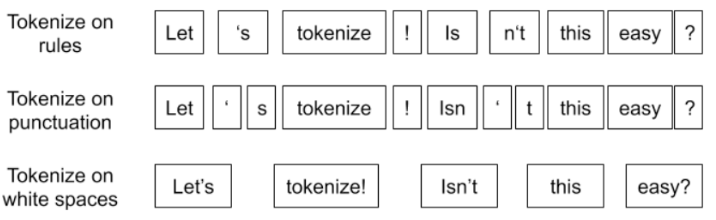

Let's simplify and think we just separate the tokens by using punctuation. In a sentence like:
`Let's tokenize! Isn't this easy?`

We would be getting:
`Let ' s tokenize ! Isn ' t this easy ?`

That's already 11 tokens to go to the vocabulary. The traditional way to build a vocabulary is was just that:
- 1) Tokenizing the corpus;
- 2) Getting each token;
- 3) Adding it to the vocabulary

**Problem**: languages may consist of 500K to 1M words, if we take into consideration different forms (is not, is, isn ' t ...) . That's something unbearable for real-time NLP architectures to cope with.

###📌 Out of Vocabulary

**1st solution**: OOV (Out of Vocabulary). The first ML/DL algorithms used to prune the vocabulary, leaving the top-N most frequent tokens seen in the corpus and discarding the rest

This approach soon run short, as the necesities to capture all the meaning of a text without discardign anything became crucial

###📌 Subword tokenization

The **2nd solution** is _subword tokenization_. The idea behind this is that we can split words into sequences of characters, if we see a probability of that sequence of characters being frequently used to form other words. For example, let's suppose we have the following sentence:

`My favourite Natural Language Processing library is clearly Spark NLP!`

The subword tokenization algorithm used by `BERT` transformers is called WordPiece. The result WordPiece returns for that sentence is:

```
['My', 'favourite', 'Natural', 'Language', 'Process', '##ing', 'library', 'is', 'clearly', 'Spa', '##rk', 'NL', '##P', '!']
```

As we can see, we got:
- `Processing` split into 2 subwords: `Process` and `##ing`. That's because `Process` seems a very common subword in the texts used to train BERT, and `ing` a very common subword (suffix) as well. The `##` means that subwords goes attached to the previous word (`Process`).
- `Spark` split into `Spa`(again, `Spa` is a common subword, for example, `Spa` in Wellness) and `##rk`
- `NLP` into `NL` and `#P`

As you have probably noticed, proper nouns are usually split in more than one subword, as also derivative words (Process - Process+ing).

This second approach is the most used in State of the Art NLP architectures, including in all the Spark NLP Transformers.

#🔎 So, what happened to our previous 192 tokens❓
When we use a Transformer model, those 192 tokens will also be split into different `subwords`, which counts as 1 for the token restriction. Example:
- `Spark NLP` is not 2 tokens, it is 4 tokens: `Spa ##rk NL ##P`

📚So our previous 192 tokens probably are already about ~400. Still inside the boundaries of Bert, but we are very close already...

| Transformer | Limit of tokens |
|-------------|-----------------|
| BERT        | 512             |
| XLNet       | 512             |
| RoBERTa     | 512             |
| XLM-RoBERTa | 512             |
| Electra     | 512             |
| Longformers*| 4096 (8 x BERT) |


#🔎 Solutions: Let's try go find sub-sentences using splitting!
As we do for paragraphs inside pages, or pages inside documents.

##✔ Default non-aggressive text splitting
Let's use several characters which don't drastically change the structure of the sentence. 

In [21]:
text = """In addition to these objective standards, the NYSE American may delist the securities of any issuer (i) if, in its opinion, the issuer’s financial condition and/or operating results appear unsatisfactory; (ii) if it appears that the extent of public distribution or the aggregate market value of the security has become so reduced as to make continued listing on the NYSE American inadvisable; (iii) if the issuer sells or disposes of principal operating assets or ceases to be an operating company; (iv) if an issuer fails to comply with the NYSE American’s listing requirements; (v) if an issuer’s securities sell at what the NYSE American considers a “low selling price” which the exchange generally considers $0.20 per share and the issuer fails to correct this via a reverse split of shares after notification by the NYSE American; or (vi) if any other event occurs or any condition exists which makes continued listing on the NYSE American, in its opinion, inadvisable. This is another sentence."""

📚For this case, just the default strategy of the Text Splitter works well:

```
Lists (“(i), (ii)”, “(a), (b)”, “1., 2.”)
Numbers
Abbreviations
Punctuations
Multiple Periods
Geo-Locations/Coordinates (“N°. 1026.253.553.”)
Ellipsis (”…”)
In-between punctuations
Quotation marks
Exclamation Points
Basic Breakers (“.”, “;”)
```

In [22]:
documentAssembler = nlp.DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")
        
textSplitter = finance.TextSplitter()\
    .setInputCols(["document"])\
    .setOutputCol("sentence")\
    .setCustomBounds([";"])\
    .setUseCustomBoundsOnly(False)

nlpPipeline = nlp.Pipeline(stages=[
        documentAssembler,
        textSplitter])

empty_data = spark.createDataFrame([[""]]).toDF("text")

model = nlpPipeline.fit(empty_data)


In [23]:
lp = nlp.LightPipeline(model)

In [24]:
lp.annotate(text)['sentence']

['In addition to these objective standards, the NYSE American may delist the securities of any issuer',
 '(i) if, in its opinion, the issuer’s financial condition and/or operating results appear unsatisfactory',
 '(ii) if it appears that the extent of public distribution or the aggregate market value of the security has become so reduced as to make continued listing on the NYSE American inadvisable',
 '(iii) if the issuer sells or disposes of principal operating assets or ceases to be an operating company',
 '(iv) if an issuer fails to comply with the NYSE American’s listing requirements',
 '(v) if an issuer’s securities sell at what the NYSE American considers a “low selling price” which the exchange generally considers $0.20 per share and the issuer fails to correct this via a reverse split of shares after notification by the NYSE American',
 'or',
 '(vi) if any other event occurs or any condition exists which makes continued listing on the NYSE American, in its opinion, inadvisable.

This splitting seems good to me, except maybe a a couple of long sentences.

However, let's take a look at another example.

In [25]:
text = 'Taiwan. Speaking only hours after Chinese state media said the time was right to engage in political talks with Taiwan, Foreign Ministry spokesman Shen Guofang told Reuters: "The necessary atmosphere for the opening of the talks has been disrupted by the Taiwan authorities."'

In [26]:
documentAssembler = nlp.DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")
        
textSplitter = finance.TextSplitter()\
    .setInputCols(["document"])\
    .setOutputCol("sentence")

nlpPipeline = nlp.Pipeline(stages=[
        documentAssembler,
        textSplitter])

empty_data = spark.createDataFrame([[""]]).toDF("text")

model = nlpPipeline.fit(empty_data)


In [27]:
lp = nlp.LightPipeline(model)

In [28]:
lp.annotate(text)['sentence']

['Taiwan.',
 'Speaking only hours after Chinese state media said the time was right to engage in political talks with Taiwan, Foreign Ministry spokesman Shen Guofang told Reuters: "The necessary atmosphere for the opening of the talks has been disrupted by the Taiwan authorities."']

That second sentence is definitely too long to process. It has much information and many tokens. Let's try to subsplit it with  `setCustomBounds()`

In [29]:
documentAssembler = nlp.DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")
        
textSplitter = finance.TextSplitter()\
    .setInputCols(["document"])\
    .setOutputCol("sentence")\
    .setCustomBounds([";", ":", "\""])\
    .setUseCustomBoundsOnly(False)

nlpPipeline = nlp.Pipeline(stages=[
        documentAssembler,
        textSplitter])

empty_data = spark.createDataFrame([[""]]).toDF("text")

model = nlpPipeline.fit(empty_data)


In [30]:
lp = nlp.LightPipeline(model)

In [31]:
lp.annotate(text)['sentence']

['Taiwan.',
 'Speaking only hours after Chinese state media said the time was right to engage in political talks with Taiwan, Foreign Ministry spokesman Shen Guofang told Reuters',
 'The necessary atmosphere for the opening of the talks has been disrupted by the Taiwan authorities.']

Much better!

##✔ Aggressive sentence-splitting
Sometimes the splitting with "conservative" techniques is not enough. In that case, you may considering breaking the sentence structure. 

This has the main caveat that you may lose context by breaking the sentence into smaller pieces.

However, if there is no other way you can split a sentence, it's better to lose some context but using all the words, than just not splitting and cutting off the sentence on the 512nd token.

Even when you are within the limits, sometimes splitting into smaller chunks helps the model repetitive patterns which may get deluded in big sentences.

Also, the performance degrades the longer the sentence is. Sometimes splitting in smaller sentences may provide with an performance improvement.

In [32]:
text = 'On June 20, 2019, Inuvo entered into an Agreement and Plan of Merger Termination Agreement (the “Merger Termination Agreement”) with ConversionPoint Technologies Inc., a Delaware corporation (“CPT”), ConversionPoint Holdings, Inc., a Delaware corporation (“Parent”), CPT Merger Sub, Inc., a Delaware corporation, (“CPT Merger Sub”), and CPT Cigar Merger Sub, Inc., a Nevada corporation (“Inuvo Merger Sub”) which, among other things, terminated the Agreement and Plan of Merger, dated November 2, 2018, by and among Inuvo, CPT, Parent, CPT Merger Sub, and Inuvo Merger Sub, as amended (the “Merger Agreement”), pursuant to which Inuvo would have merged with and into Inuvo Merger Sub and become a wholly-owned subsidiary of Parent, and CPT would have merged with and into CPT Merger Sub and become a wholly-owned subsidiary of Parent (the “Mergers”), and (2) terminated each of the Support Agreements that were entered into by certain officers and directors of Inuvo and the parties to the Merger Agreement"'

In [33]:
documentAssembler = nlp.DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")
        
textSplitter = finance.TextSplitter()\
    .setInputCols(["document"])\
    .setOutputCol("sentence")\
    .setCustomBounds([";","\""])\
    .setUseCustomBoundsOnly(False)

nlpPipeline = nlp.Pipeline(stages=[
        documentAssembler,
        textSplitter])

empty_data = spark.createDataFrame([[""]]).toDF("text")

model = nlpPipeline.fit(empty_data)


In [34]:
lp = nlp.LightPipeline(model)

In [35]:
lp.annotate(text)['sentence']

['On June 20, 2019, Inuvo entered into an Agreement and Plan of Merger Termination Agreement (the “Merger Termination Agreement”) with ConversionPoint Technologies Inc., a Delaware corporation (“CPT”), ConversionPoint Holdings, Inc., a Delaware corporation (“Parent”), CPT Merger Sub, Inc., a Delaware corporation, (“CPT Merger Sub”), and CPT Cigar Merger Sub, Inc., a Nevada corporation (“Inuvo Merger Sub”) which, among other things, terminated the Agreement and Plan of Merger, dated November 2, 2018, by and among Inuvo, CPT, Parent, CPT Merger Sub, and Inuvo Merger Sub, as amended (the “Merger Agreement”), pursuant to which Inuvo would have merged with and into Inuvo Merger Sub and become a wholly-owned subsidiary of Parent, and CPT would have merged with and into CPT Merger Sub and become a wholly-owned subsidiary of Parent (the “Mergers”), and (2) terminated each of the Support Agreements that were entered into by certain officers and directors of Inuvo and the parties to the Merger A

Conservative splitting does not help

Splitting by parethensis

In [36]:
documentAssembler = nlp.DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")
        
textSplitter = finance.TextSplitter()\
    .setInputCols(["document"])\
    .setOutputCol("sentence")\
    .setCustomBounds(["\(","\)"])\
    .setUseCustomBoundsOnly(False)

nlpPipeline = nlp.Pipeline(stages=[
        documentAssembler,
        textSplitter])

empty_data = spark.createDataFrame([[""]]).toDF("text")

model = nlpPipeline.fit(empty_data)


In [37]:
lp = nlp.LightPipeline(model)

In [38]:
lp.annotate(text)['sentence']

['On June 20, 2019, Inuvo entered into an Agreement and Plan of Merger Termination Agreement',
 'the “Merger Termination Agreement”',
 'with ConversionPoint Technologies Inc., a Delaware corporation',
 '“CPT”',
 ', ConversionPoint Holdings, Inc., a Delaware corporation',
 '“Parent”',
 ', CPT Merger Sub, Inc., a Delaware corporation,',
 '“CPT Merger Sub”',
 ', and CPT Cigar Merger Sub, Inc., a Nevada corporation',
 '“Inuvo Merger Sub”',
 'which, among other things, terminated the Agreement and Plan of Merger, dated November 2, 2018, by and among Inuvo, CPT, Parent, CPT Merger Sub, and Inuvo Merger Sub, as amended',
 'the “Merger Agreement”',
 ', pursuant to which Inuvo would have merged with and into Inuvo Merger Sub and become a wholly-owned subsidiary of Parent, and CPT would have merged with and into CPT Merger Sub and become a wholly-owned subsidiary of Parent',
 'the “Mergers”',
 ', and',
 '2',
 'terminated each of the Support Agreements that were entered into by certain officers a

We can use **REGEX** or just several characters in a row in our `setCustomBounds`to be able to have finegrain splits.

In [39]:
documentAssembler = nlp.DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")
        
textSplitter = finance.TextSplitter()\
    .setInputCols(["document"])\
    .setOutputCol("sentence")\
    .setUseCustomBoundsOnly(False)\
    .setCustomBounds([", and"])

nlpPipeline = nlp.Pipeline(stages=[
        documentAssembler,
        textSplitter])

empty_data = spark.createDataFrame([[""]]).toDF("text")

model = nlpPipeline.fit(empty_data)


In [40]:
lp = nlp.LightPipeline(model)

In [41]:
lp.annotate(text)['sentence']

['On June 20, 2019, Inuvo entered into an Agreement and Plan of Merger Termination Agreement (the “Merger Termination Agreement”) with ConversionPoint Technologies Inc., a Delaware corporation (“CPT”), ConversionPoint Holdings, Inc., a Delaware corporation (“Parent”), CPT Merger Sub, Inc., a Delaware corporation, (“CPT Merger Sub”)',
 'CPT Cigar Merger Sub, Inc., a Nevada corporation (“Inuvo Merger Sub”) which, among other things, terminated the Agreement and Plan of Merger, dated November 2, 2018, by and among Inuvo, CPT, Parent, CPT Merger Sub',
 'Inuvo Merger Sub, as amended (the “Merger Agreement”), pursuant to which Inuvo would have merged with and into Inuvo Merger Sub and become a wholly-owned subsidiary of Parent',
 'CPT would have merged with and into CPT Merger Sub and become a wholly-owned subsidiary of Parent (the “Mergers”)',
 '(2) terminated each of the Support Agreements that were entered into by certain officers and directors of Inuvo and the parties to the Merger Agree

##📜 Conclusions
In this notebook we will show you several techniques and their caveats to properly split Sentences so that you reduce your sentence length after tokenization.

Doing this has proved to be better even when you are within the limits of your sentence token length (512) - smaller chunks of pieces of text are better managed than long sequences.